First, load the data,in this notebook we are using the Qitta data from the paper "Machine learning–based feature selection to search stable microbial biomarkers: application to inflammatory bowel disease". The data has been preprocessed in R (refer to the r script in iCloud/UTK/GRA-UTK/SelectMicro/MLonMicrobiome).

There are 3 datasets, the orginal paper combined the 3 datasets together, but not sure how they are combined since they have different columns. The imbalance is an issue if analyzing each dataset independently.

this notebook is for testing multiple classes, it worked for featur selection, but the code for ML part should  be edit.

In [1]:
import sys
sys.path.append('../Code')
import loadData 
import RunML
import RunML_continue
import FS
import metric

import pandas as pd
import numpy as np
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import pickle

In [2]:
qitta_combine = pd.read_csv('../Data/Qitta_3datasetscombined.csv',index_col=0)

In [3]:
print(qitta_combine.shape)

(1569, 3836)


In [4]:
#print(cols_name)

Extract OTU table and response variable

In [5]:
data = qitta_combine.drop(qitta_combine.columns[0], axis=1)
cols_name = data.columns.tolist()
data = data.values

In [6]:
print(data)
print(np.shape(data))

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(1569, 3835)


In [7]:
y = qitta_combine.iloc[:, 0].values 

In [8]:
set(y)

{'CD', 'UC', 'nonIBD'}

In [9]:
#change y into 2 levels
#y = np.where(np.isin(y, ['CD', 'UC']), 'IBD', y)

In [10]:
pd.Series(y).value_counts()

nonIBD    867
UC        366
CD        336
Name: count, dtype: int64

preprocess the OTU table

In [11]:
# 1. abundance matrix--> relative abundance matrix
data=FS.relative_abundance(data)
print(np.shape(data))

(1569, 3835)


In [12]:
data

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 3.84791501e-06, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]])

Perform sigle lable feature selection, this is done by calculating Kruskal-Wallis H-test on each OTU for each environmental factor, each OTU/ASV is given a weighted h score.

In [13]:
# 2. calculating H score for each OTU
weights=FS.OTU_H_Score_fun(data,y)

In [14]:
print(min(weights));print(max(weights))

0.0
203.9848645997788


In [15]:
weights

array([0.80968858, 0.        , 0.        , ..., 0.        , 2.43216536,
       0.        ])

In [16]:
len(np.unique(y))

3

In [17]:
# 3. determine the elbowpoint and the select indices of the features
selectedOTU_index, eps=FS.indice_H_sig(weights,y)

In [18]:
print(eps)

342


In [19]:
eps

342

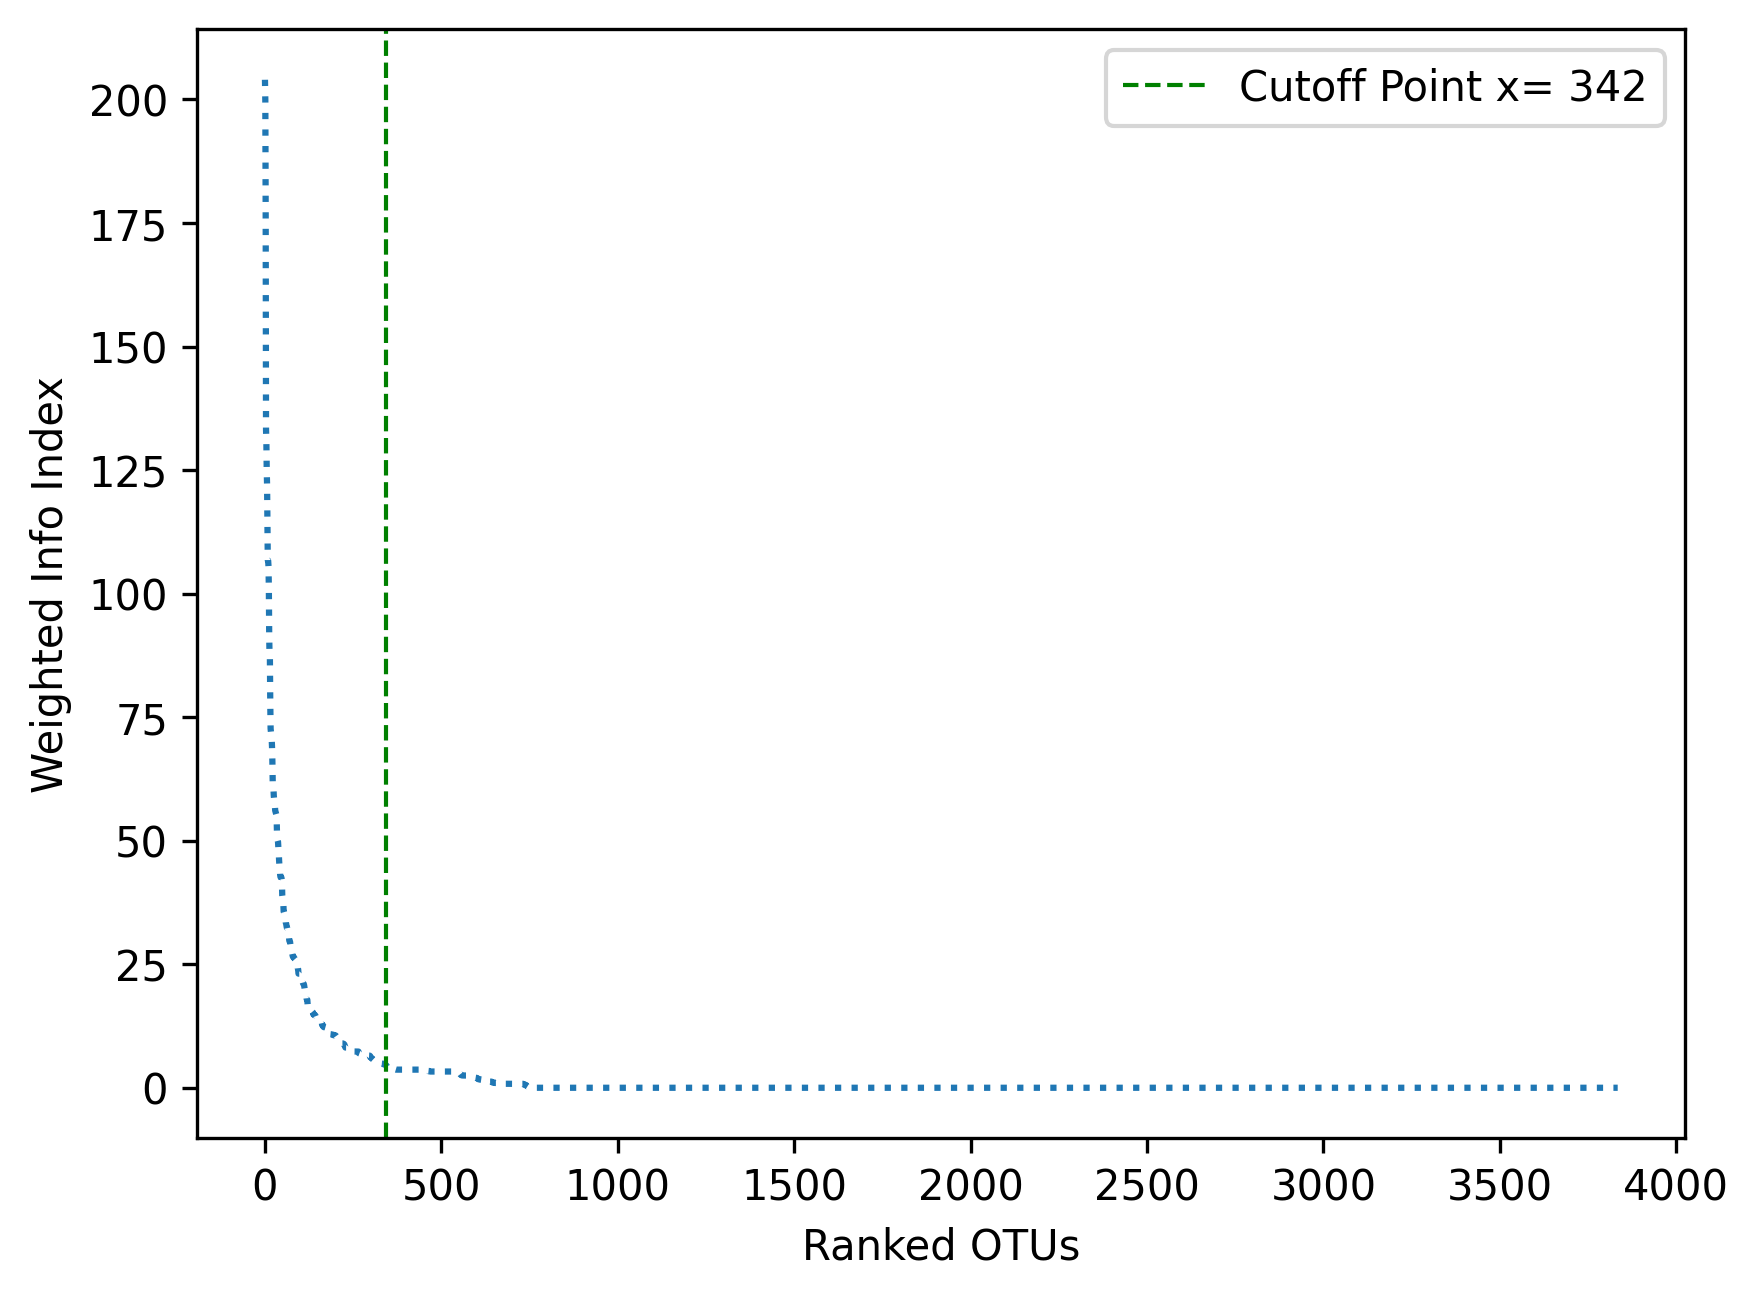

In [20]:
#plot the h statistics and cutoff descendingly
FS.plotWeightedIndex(weights,threshold=eps)

This plot shows that the gain in information decreases as we include more OTUs along the ranks. 

In [21]:
# 4. subset the relative matrix by the select indices

In [22]:
X_FS = data[:,selectedOTU_index]

In [23]:
np.shape(X_FS)

(1569, 342)

Prepare 4 datasets: full dataset, our selected dataset, Lasso selected  dataset(based on the target variable), randomly selected data (selected the same numer of variables as in our method, repeat the  process iter=20 times to  find the mean accuracy and AUC)---> use random forest and SVM as classifier

In [24]:
iter =10
cls = ["RF","SVM"]

In [25]:
targetLabel=y
X_lasso = RunML_continue.LassoFeatureSelection(data,targetLabel)# this is depend on the target variable(do not update here)
print(np.shape(X_lasso))

(1569, 549)


In [26]:
data_subset = {"AllFeatures":data, 
               "SelectMicro": X_FS,
               "Lasso":X_lasso,
               "Random":data
              }
print(np.shape(data))
print(np.shape(X_FS))
print(np.shape(X_lasso))

(1569, 3835)
(1569, 342)
(1569, 549)


started modeling, the  function will print out the accuracy and AUC for each dataset using each classifier. and also will return the y_actual, y_predict, y_predprob

In [27]:
# the result of 5-fold cross validation
dict_cm = RunML_continue.runClassifier_FScompare(data_subsets= data_subset,y= targetLabel,N=iter,classifiers=cls)

ValueError: multi_class must be in ('ovo', 'ovr')

In [ ]:
# Save dictionary to a pickle file
with open('../results/dict_cm_qitta_update.pkl', 'wb') as pickle_file:
    pickle.dump(dict_cm, pickle_file)

In [ ]:
# Load dictionary from the pickle file
with open('../results/dict_cm_qitta_update.pkl', 'rb') as pickle_file:
    dict_cm = pickle.load(pickle_file)

In [ ]:
# do not use plotmacro_confusion_matrices (not for binary classification)
for dataset_name, classifiers in dict_cm.items():
        for classifier_name, labels in classifiers.items():
            actual_labels = labels[0]
            predicted_labels = labels[1]
            metric.plotmacro_confusion_matrices(actual_labels, predicted_labels,f"{dataset_name} - {classifier_name}")

## compare the first 15 index

In [ ]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
# the   df with the largest H statistics features
entries=30
selectedOTU_index_15=selectedOTU_index[:entries]
X_FS_15=data[:,selectedOTU_index_15]
df=pd.DataFrame(data=X_FS_15)

In [ ]:
# the column names of the featues
ASVs = cols_name
selectedASVs=[ASVs[i] for i in selectedOTU_index_15]

In [ ]:
print(set(targetLabel))
RunML.plotPresenseRatio(X_FS_15,targetLabel,selectedASVs,posLabel="IBD",posText="IBD",negText="nonIBD",entries=entries)